
# e-Sensing: Big Earth observation data analytics for land use and land cover change information

The e-Sensing project aims at conceiving, building and deploying a knowledge platform for organization, access, processing and analysis of big Earth Observation data. The e-Sensing project is developed at the National Institute for Space Research (INPE). It is a 4 years project funded by the São Paulo Research Foundation (FAPESP).
<center>
<table align="center">
<tr>
<td>
<img src="esensing4.png" alt="e-Sensing project" width=650> 
</td>
<td>
<a href="http://www.esensing.org" alt="Project website">Project website</a><br>
<a href="https://github.com/e-sensing" alt="Code repository">GitHub Repository</a>
</td>
</tr>
</table>
</center>

## The e-Sensing data cube ##
Our approach is based on a data cube, providing time series of EO data to be analyzed in a "time-first space-later" approach. This approach is better suited to represent processes of land change.

<table align="center">
<tr>
<td>
<img src="timefirst.png" alt="time-first, space-later" width=550></td>
</tr>
</table>

In this demonstration we will show some results of the project using a Jupyter Notebook to running R scripts. 

### WTSS - Web Time Series Service ###

We have created a lightweight JSON web service to access the data cube, with three main capabilities:
- listing of the coverages available in the data cube;
- description of coverage;
- retrieving of the time series of a coverage in a given location.

We have an instance of a WTSS server running at INPE. We will demonstrate the acesso to it using a WTSS R client, and also its integration with other R packages.

In [1]:
library(wtss)

ts.server <- WTSS("http://www.dpi.inpe.br/tws/wtss")
coverages <- listCoverages(ts.server)
coverages

[1] "itobi"       "merge"       "mixl8mod"    "mixl8mod_f"  "mod13q1_512"

In [2]:
coverage.name <- "mod13q1_512"
cv_scheme =  describeCoverage(ts.server, coverage.name)
cv_scheme[[names(cv_scheme)]]

$name
[1] "mod13q1_512"

$description
[1] "Vegetation Indices 16-Day L3 Global 250m"

$detail
[1] "https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod13q1"

$dimensions
$dimensions$x
$dimensions$x$name
[1] "col_id"

$dimensions$x$min_idx
[1] 0

$dimensions$x$max_idx
[1] 172799


$dimensions$y
$dimensions$y$name
[1] "row_id"

$dimensions$y$min_idx
[1] 0

$dimensions$y$max_idx
[1] 86399


$dimensions$t
$dimensions$t$name
[1] "time_id"

$dimensions$t$min_idx
[1] 0

$dimensions$t$max_idx
[1] 376



$attributes
  name                            description datatype valid_range.min
1 ndvi                      250m 16 days NDVI    int16           -2000
2  evi                       250m 16 days EVI    int16           -2000
3  red  250m 16 days red reflectance (Band 1)    int16               0
4  nir  250m 16 days NIR reflectance (Band 2)    int16               0
5 blue 250m 16 days blue reflectance (Band 3)    int16               0
6  mir  250m 16 days MIR reflectance (Ban

In [5]:
attributes <- cv_scheme[[names(cv_scheme)]]$attributes$name

long <- -59.11
lat <- -14.91

start <- "2000-02-18"
end <- "2017-02-18"
  
mod13q1_ts = timeSeries(object = ts.server, 
                coverages = coverage.name, 
                attributes = attributes, 
                latitude = lat, 
                longitude = long, 
                start = start, 
                end = end)

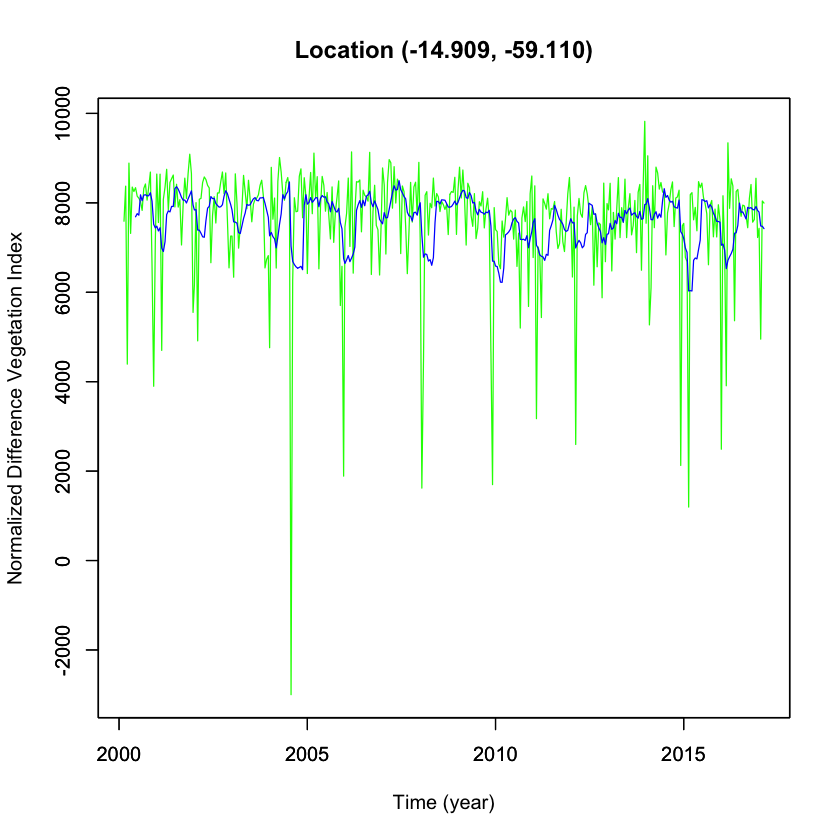

In [10]:
plot(mod13q1_ts[[1]]$attributes[,1], 
     main=sprintf("Location (%5.3f, %5.3f)", 
                  mod13q1_ts[[1]]$center_coordinate$latitude, mod13q1_ts[[1]]$center_coordinate$longitude), 
     xlab="Time (year)", 
     ylab="Normalized Difference Vegetation Index", col="green", col.lab="black")

# Smoothing the time series using a third-party R package
library("TTR")
smoothed_nvi <- SMA(mod13q1_ts[[1]]$attributes[,1],n=8)
par(new=TRUE)
plot(smoothed_nvi,ylim=range(mod13q1_ts[[1]]$attributes[,1]),xlab = "", ylab = "", col="blue")

## SITS - Satellite Image Time Series Analysis ##

A set of tools for working with satellite image time series.
- Supports data retrieval using WTSS (web time series service).
- Provides different visualisation methods specially designed for image time series.
- Provides smoothing methods for noisy time series.
- Provides a set of methods for image time series classifation, based on pattern recognition techiniques
- Classifies time series using TWDTW method contained in the dtwSat package.
- ...


## SITS - Satellite Image Time Series Analysis ##

In the next examples we show how to retrieve the time series and execute some visualization and processing in a friendly way using SITS

In [12]:
library(sits)

URL <- "http://www.dpi.inpe.br/tws/wtss"
wtss_inpe <- sits_infoWTSS(URL)

# get information about a specific coverage
sits_coverageWTSS(URL,"mod13q1_512")


-----------------------------------------------------------
The WTSS server URL is http://www.dpi.inpe.br/tws/wtss
Available coverages: 
itobi
merge
mixl8mod
mixl8mod_f
mod13q1_512
------------------------------------------------------------
----------------------------------------------------------------------------------
Coverage: mod13q1_512
Description: Vegetation Indices 16-Day L3 Global 250m
Source: https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod13q1
Bands: 
  name                            description
1 ndvi                      250m 16 days NDVI
2  evi                       250m 16 days EVI
3  red  250m 16 days red reflectance (Band 1)
4  nir  250m 16 days NIR reflectance (Band 2)
5 blue 250m 16 days blue reflectance (Band 3)
6  mir  250m 16 days MIR reflectance (Band 7)

Spatial extent: (-180, -90) - (180, 90)
Spatial resolution: (0.00208334, 0.00208334)
Projection CRS: +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs
Time range: 2000-02-18 to 2017-02

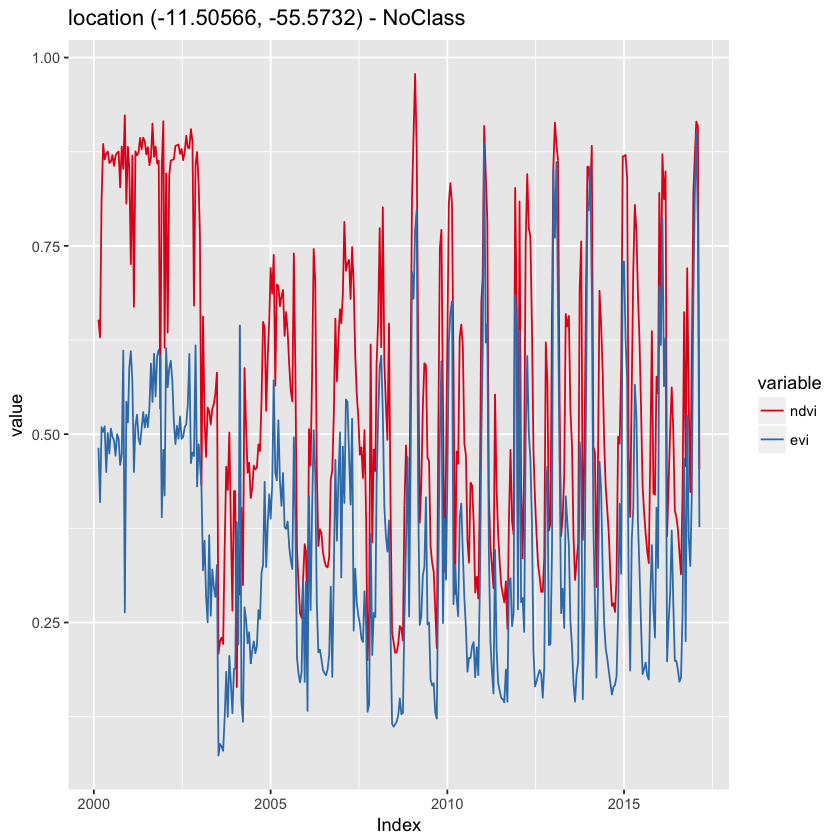

In [23]:
# choose a coverage
coverage <- "mod13q1_512"
# recover all bands
bands <- c("ndvi", "evi", "nir")
# a point in the transition forest pasture in Northern MT
long <- -55.57320
lat <- -11.50566

# obtain a time series from the WTSS server for this point
series.tb <- sits_getdata(longitude = long, latitude = lat, URL = URL, coverage = "mod13q1_512", bands = bands)

# plot the series
#sits_plot(series.tb) # all bands
sits_plot(sits_select(series.tb, bands = c("ndvi","evi")))


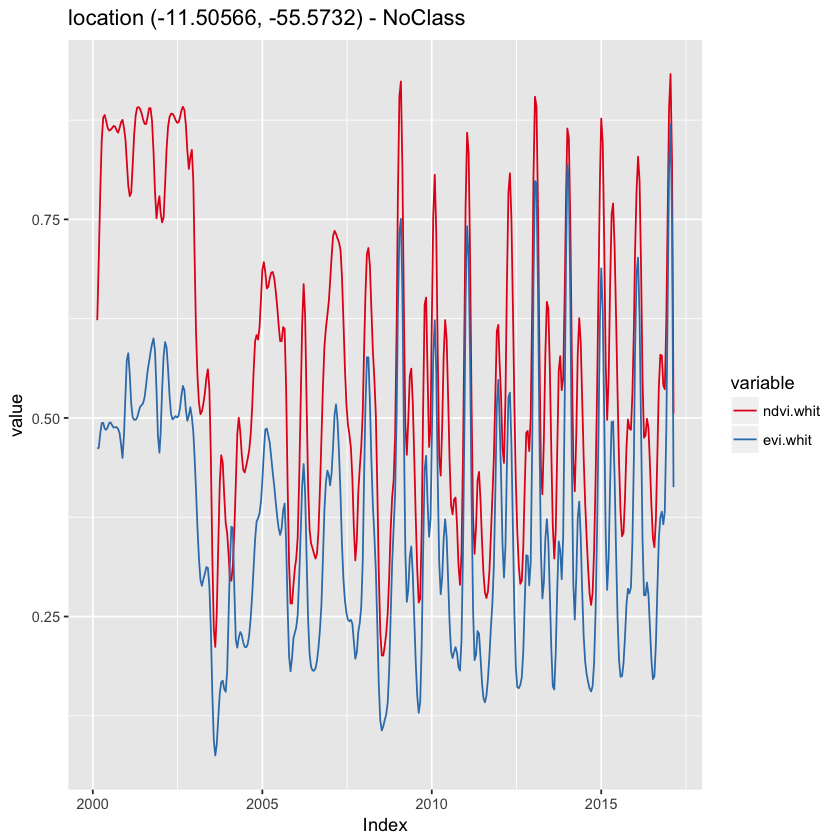

In [24]:
# filtering the series using the Whittaker filter
series_fil.tb <- series.tb %>% 
  sits_whittaker(lambda=1)  

#sits_plot(series_fil.tb) # all bands
sits_plot(sits_select(series_fil.tb, bands = c("ndvi.whit", "evi.whit")))


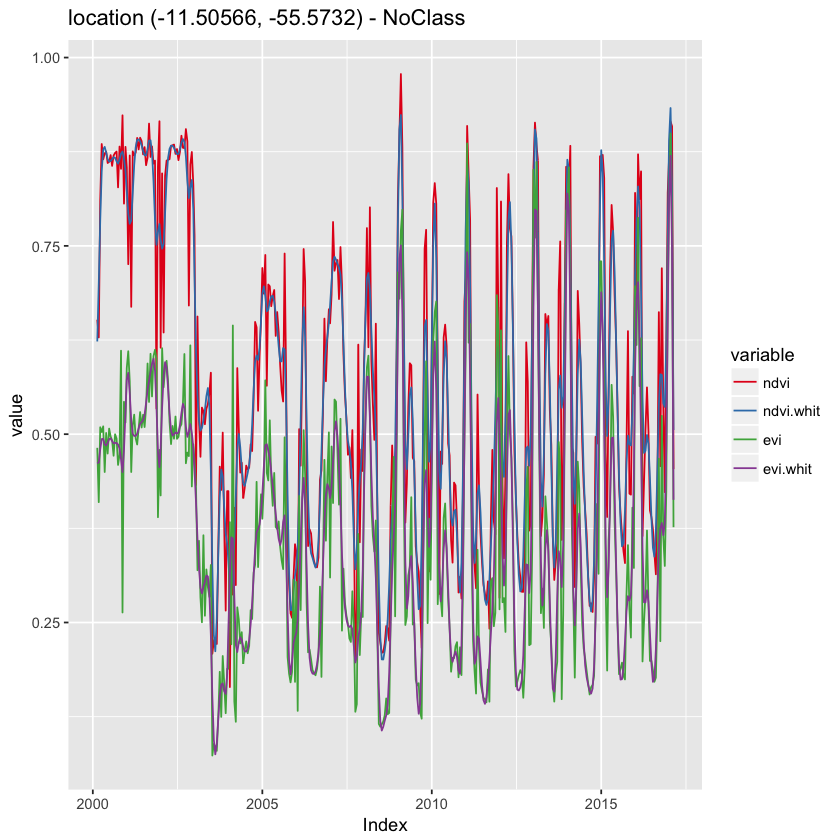

In [25]:
# plot two series.tb and series_fil.tb together by bands
series.tb %>% 
  sits_merge(series_fil.tb) %>% 
  sits_select(bands = c("ndvi","ndvi.whit","evi","evi.whit")) %>% 
  sits_plot()

## SITS - Satellite Image Time Series Analysis ##

In the next examples we show how to execute time series classification experiments using SITS.

Our time series classification methods are based on  machine learning techniques. We assume that EO time series classification is a problem in which our theoretical knowledge is still incomplete but we do have a significant number of observations and other data to be explored.

<table align="center">
<tr>
<td><img src="lucc.png" alt="land use patterns" width=550></td>
</tr>
</table>


# Learning representation

We start by considering sets of sample locations that were classified by experts, by visual interpretation or by field trips.

In [27]:
# retrieve a set of samples from an RDS file
embrapa_mt.tb <- readRDS("embrapa_mt.rds")
embrapa_mt.tb

longitude,latitude,start_date,end_date,label,coverage,time_series
-55.1852,-10.8378,2013-09-14,2014-08-29,Pasture,mod13q1_512,"15962.0000, 15978.0000, 15994.0000, 16010.0000, 16026.0000, 16042.0000, 16058.0000, 16071.0000, 16087.0000, 16103.0000, 16119.0000, 16135.0000, 16151.0000, 16167.0000, 16183.0000, 16199.0000, 16215.0000, 16231.0000, 16247.0000, 16263.0000, 16279.0000, 16295.0000, 16311.0000, 0.4245, 0.4673, 0.5039, 0.6489, 0.7956, 0.7248, 0.7971, 0.8049, 0.7364, 0.7870, 0.3345, 0.8220, 0.6921, 0.7117, 0.7030, 0.6593, 0.6197, 0.5713, 0.4853, 0.4180, 0.4099, 0.4234, 0.4512, 0.2800, 0.2642, 0.2993, 0.4071, 0.6692, 0.5400, 0.5574, 0.7228, 0.6867, 0.7342, 0.2746, 0.4434, 0.5242, 0.4988, 0.4334, 0.4332, 0.3307, 0.3080, 0.2811, 0.2557, 0.2592, 0.2491, 0.2880, 0.2879, 0.2570, 0.2659, 0.2762, 0.4552, 0.3661, 0.3490, 0.5255, 0.5165, 0.5320, 0.3263, 0.2755, 0.4150, 0.3735, 0.3114, 0.3327, 0.2509, 0.2548, 0.2696, 0.3058, 0.3135, 0.2928, 0.2838, 0.2439, 0.1672, 0.2019, 0.1026, 0.0875, 0.0799, 0.0478, 0.1030, 0.1449, 0.1323, 0.0793, 0.0503, 0.0957, 0.0888, 0.0879, 0.1172, 0.1002, 0.1124, 0.1678, 0.1574, 0.1699, 0.1524, 0.1892, 0.0605, 0.0357, 0.0405, 0.0266, 0.0271, 0.0516, 0.0171, 0.0327, 0.0629, 0.0452, 0.1498, 0.0047, 0.0332, 0.0259, 0.0206, 0.0289, 0.0204, 0.0224, 0.0351, 0.0395, 0.0457, 0.0342, 0.0528, 0.1163, 0.0933, 0.0877, 0.0588, 0.0518, 0.0584, 0.0394, 0.0568, 0.0784, 0.0634, 0.1627, 0.0269, 0.0755, 0.0629, 0.0543, 0.0683, 0.0589, 0.0695, 0.0934, 0.1255, 0.1312, 0.1186, 0.1073"
-57.7940,-9.7573,2006-09-14,2007-08-29,Pasture,mod13q1_512,"13405.0000, 13421.0000, 13437.0000, 13453.0000, 13469.0000, 13485.0000, 13501.0000, 13514.0000, 13530.0000, 13546.0000, 13562.0000, 13578.0000, 13594.0000, 13610.0000, 13626.0000, 13642.0000, 13658.0000, 13674.0000, 13690.0000, 13706.0000, 13722.0000, 13738.0000, 13754.0000, 0.5874, 0.7186, 0.5581, 0.6957, 0.5839, 0.5273, 0.7446, 0.7469, 0.6896, 0.8385, 0.8146, 0.6408, 0.7602, 0.6473, 0.7555, 0.7344, 0.6890, 0.6865, 0.5710, 0.5350, 0.4560, 0.4309, 0.5554, 0.4405, 0.4797, 0.3354, 0.5035, 0.4206, 0.4911, 0.4400, 0.5199, 0.9548, 0.5902, 0.5312, 0.5861, 0.4997, 0.4093, 0.3867, 0.5188, 0.4441, 0.4385, 0.3418, 0.3149, 0.2465, 0.2384, 0.3620, 0.0586, 0.0267, 0.0341, 0.0523, 0.0429, 0.1027, 0.0177, 0.0299, 0.1313, 0.0152, 0.0082, 0.0720, 0.0223, 0.0498, 0.0162, 0.0266, 0.0254, 0.0270, 0.0321, 0.0342, 0.0362, 0.0425, 0.0448, 0.0888, 0.0551, 0.0800, 0.0546, 0.0986, 0.1080, 0.0427, 0.0501, 0.0790, 0.0333, 0.0367, 0.0989, 0.0453, 0.0533, 0.0328, 0.0567, 0.0599, 0.0587, 0.0774, 0.0829, 0.0875, 0.0925, 0.0856, 0.3417, 0.3366, 0.2821, 0.3043, 0.3754, 0.3490, 0.2918, 0.3459, 0.4301, 0.3792, 0.3593, 0.4518, 0.3326, 0.2490, 0.2356, 0.3703, 0.3254, 0.3158, 0.2835, 0.2737, 0.2342, 0.2326, 0.2995, 0.1900, 0.1228, 0.1437, 0.0855, 0.1640, 0.1118, 0.0783, 0.0975, 0.1633, 0.0610, 0.0704, 0.0840, 0.0784, 0.0806, 0.0433, 0.0824, 0.0932, 0.0941, 0.1178, 0.1263, 0.1359, 0.1561, 0.2024"
-51.9412,-13.4198,2014-09-14,2015-08-29,Pasture,mod13q1_512,"16327.0000, 16343.0000, 16359.0000, 16375.0000, 16391.0000, 16407.0000, 16423.0000, 16436.0000, 16452.0000, 16468.0000, 16484.0000, 16500.0000, 16516.0000, 16532.0000, 16548.0000, 16564.0000, 16580.0000, 16596.0000, 16612.0000, 16628.0000, 16644.0000, 16660.0000, 16676.0000, 0.3450, 0.3437, 0.3510, 0.5275, 0.7310, 0.4390, 0.6657, 0.5986, 0.5677, 0.6045, 0.6153, 0.6285, 0.6835, 0.7572, 0.7285, 0.6774, 0.6294, 0.5542, 0.4808, 0.4144, 0.3684, 0.3467, 0.3191, 0.1784, 0.2177, 0.2138, 0.3603, 0.5221, 0.3591, 0.4327, 0.3813, 0.3618, 0.3498, 0.3544, 0.3351, 0.4543, 0.4556, 0.4737, 0.3753, 0.3447, 0.2567, 0.2303, 0.1972, 0.1877, 0.1903, 0.1781, 0.2146, 0.2533, 0.2750, 0.2871, 0.3462, 0.3499, 0.3229, 0.3019, 0.3134, 0.2792, 0.2713, 0.2455, 0.3421, 0.2983, 0.3254, 0.2595, 0.2590, 0.1977, 0.2045, 0.2022, 0.2206, 0.2513, 0.2484, 0.1525, 0.2500, 0.2147, 0.1533, 0.1258, 0.1824, 0.1332, 0.1419, 0.1569, 0.1271, 0.1436, 0.1131, 0.1226, 0.0764, 0.0960, 0.0988, 0.1174, 0.1357, 0.1508, 0.1699, 0.18

# Learning representation

Next we use the samples to create a representation feature of the land use we are interested in.

Aligning samples time series intervals...


  |======================================================================| 100%


Applying GAM to get time series patterns...


  |======================================================================| 100%


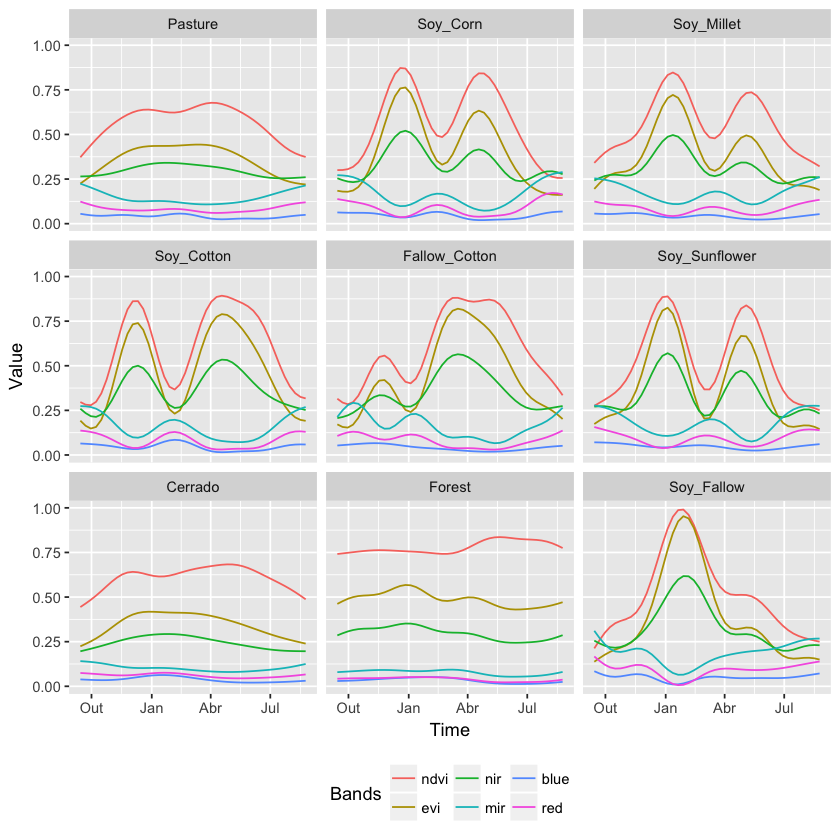

In [29]:
# obtain a set of patterns for these samples
patterns.tb <- sits_patterns(embrapa_mt.tb)
sits_plot_patterns(patterns.tb)

# TWDTW

The TWDTW method is an algorithm that measures the dissimilarity between the land use patterns and the time series. 

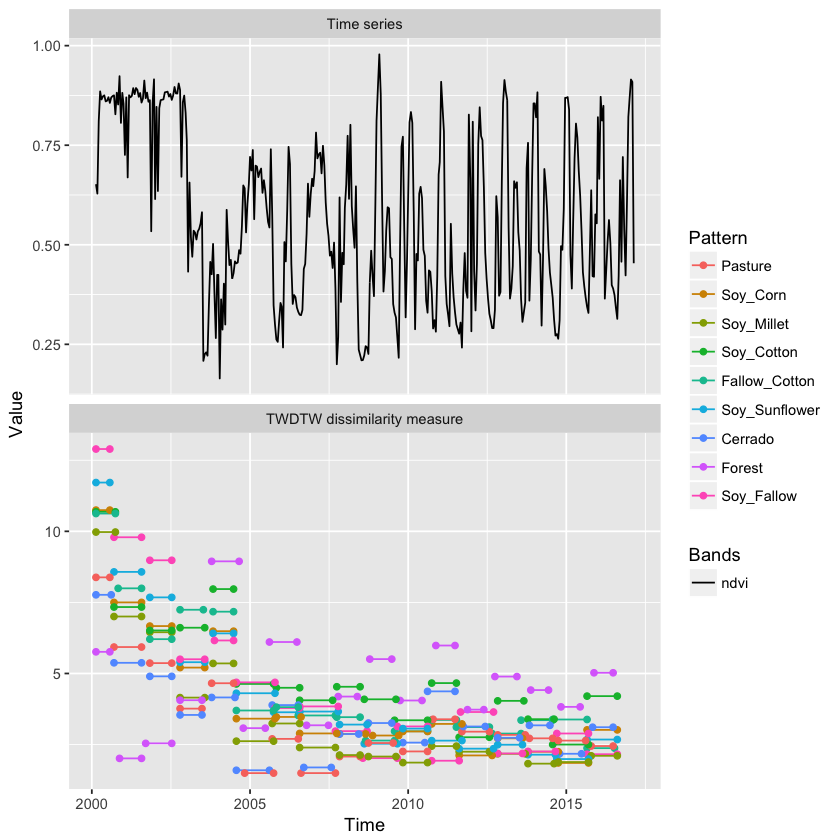

In [31]:
# find the matches between the patterns and the time series using the TWDTW algorithm
# (uses the dtwSat R package)
matches <- sits_TWDTW_matches(series.tb, patterns.tb, bands, alpha= -0.1, beta = 100, theta = 0.5, keep = TRUE)

# plot the alignments of the time series
sits_plot_TWDTW_alignments (matches)


In [ ]:
#classify the time series matches using yearly intervals
results.tb <- sits_TWDTW_classify(matches, series.tb, start_date = "2000-08-01", end_date = "2016-07-31",
                                  interval = "12 month")

# plot the classification of the time series by yearly intervals
sits_plot_TWDTW_classification (matches)